## <b>4.5 VALIDACIÓ, AVALUACIÓ I CONTROL DE QUALITAT</b>

Dades carregades OK
Freq shapes: (69740, 39) (35815, 39)
Sev shapes: (16259, 29) (3387, 29)
Ratio shapes: (69740, 20) (35815, 20)
[LightGBM] [Info] Number of positive: 16259, number of negative: 53481
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4729
[LightGBM] [Info] Number of data points in the train set: 69740, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.233137 -> initscore=-1.190680
[LightGBM] [Info] Start training from score -1.190680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3907
[LightGBM] [Info] Number of data points in the train set: 16259, number of used features: 25
[LightGBM] [Info] Start training from score 854.327142
[LightGBM] [Warning] No further 

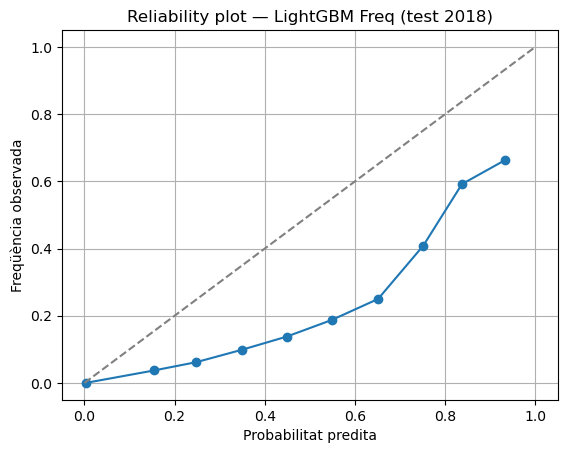

Brier Score: 0.1052357230263064

Fitxers guardats correctament.


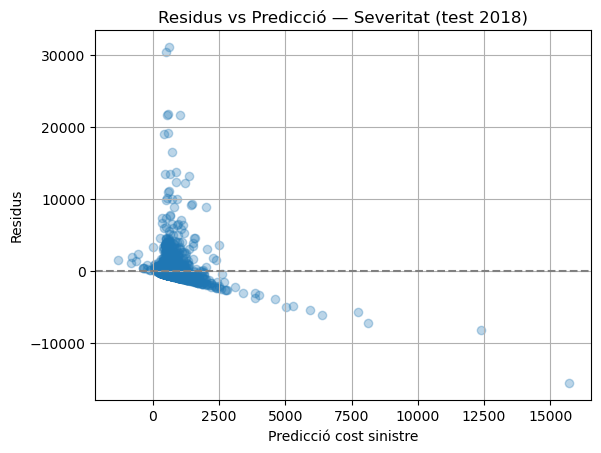


=== 4.5 COMPLETAT CORRECTAMENT ===


In [1]:
# ==========================================================
# 4.5 VALIDACIÓ, AVALUACIÓ I CONTROL DE QUALITAT
# ==========================================================
# Objectiu:
#   - Validar els models "champion" definits a 4.4:
#        * LightGBMClassifier (freqüència)
#        * LightGBMRegressor (severitat)
#   - Avaluar rendiment real sobre el cohort temporal 2018.
#   - Analitzar calibratge, residus i fiabilitat del model.
# ==========================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier, LGBMRegressor

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    log_loss,
    brier_score_loss,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    f1_score,
)
from sklearn.calibration import calibration_curve

# ==========================================================
# 0. FUNCIONS AUXILIARS: PREPARACIÓ, ALINEACIÓ I AVALUACIÓ
# son les mateixes amb les que hem treballa en l'apartat
# 4.4 MODELATGE PREDICTIU 
# ==========================================================

def prepare_xy_class_freq(df: pd.DataFrame, target: str = "Has_claims_year"):
    """
    Prepara X i y per a la tasca de freqüència (classificació binària).

    Variables que es descarten explícitament (totes existeixen a freq_gbm_*):
      - target: Has_claims_year
      - ID, Policy_year, set_type: metadades i informació temporal.
      - Cost_claims_year i transformacions (log, cap): target de severitat.
      - Claims_to_premium_ratio: ràtio econòmica ex-post basada en el cost.
    """
    if target not in df.columns:
        raise ValueError(f"Falta la columna target '{target}' al dataset de freqüència.")

    exclude = [
        target,              # Has_claims_year
        "ID",
        "Policy_year",
        "set_type",
        "Cost_claims_year",
        "Cost_claims_year_log",
        "Cost_claims_year_cap",
        "Claims_to_premium_ratio",
    ]
    # Només eliminem columnes que realment existeixen en aquest df
    exclude = [c for c in exclude if c in df.columns]

    X = df.drop(columns=exclude)
    y = df[target].astype(int)

    return X, y

def prepare_xy_severity(df: pd.DataFrame, target: str = "Cost_claims_year"):
    """
    Prepara X i y per als models de severitat (regressió).

    Condicions:
      - Si existeix Has_claims_year, ens quedem només amb sinistres = 1.
      - S'imposa target > 0 (Gamma no admet 0 ni negatius).

    Es descarten explícitament (totes existeixen a sev_*):
      - target i transformacions: Cost_claims_year, _log, _cap
      - Claims_to_premium_ratio i Claims_to_premium_ratio.1
      - Ràtios de severitat: Sev_cost_to_premium, Sev_value_to_premium
      - Metadades: ID, Policy_year, set_type
      - Qualsevol altra variable que comenci per "Sev_"
    """
    if target not in df.columns:
        raise ValueError(f"Falta la columna target '{target}' al dataset de severitat.")

    # 1) Filtrar per sinistres reals, si escau
    if "Has_claims_year" in df.columns:
        df = df[df["Has_claims_year"] == 1].copy()

    # 2) Cost > 0
    df = df[df[target] > 0].copy()

    # 3) Columnes a excloure (totes existeixen a sev_train/test)
    exclude = [
        target,              # Cost_claims_year
        "ID",
        "Policy_year",
        "set_type",
        "Claims_to_premium_ratio",
        "Cost_claims_year_log",
        "Cost_claims_year_cap",
        "Sev_cost_to_premium",
        "Sev_value_to_premium",
    ]

    # 4) Afegim qualsevol columna addicional que comenci per "Sev_"
    sev_like_cols = [c for c in df.columns if c.startswith("Sev_")]
    exclude = exclude + sev_like_cols

    # 5) Només eliminem les columnes que realment existeixen al df actual
    exclude = [c for c in exclude if c in df.columns]

    # 6) Preparem X i y
    X = df.drop(columns=exclude)
    y = df[target]

    # Sanitització del target per si hi hagués valors no finits
    y = y.replace([np.inf, -np.inf], np.nan).fillna(y.median())
    y = y.clip(lower=1e-6)

    return X, y

def prepare_xy_ratio(df: pd.DataFrame, target: str = "Claims_to_premium_ratio"):
    """
    Prepara X i y per al model directe de ràtio econòmica.

    Dataset ratio_* (totes les columnes mencionades existeixen a ratio_train/test):
      - target: Claims_to_premium_ratio
      - ID, Policy_year, set_type: metadades
      - Cost_claims_year i transformacions (si hi fossin)
    """
    if target not in df.columns:
        raise ValueError(f"Falta la columna '{target}' al dataset de ràtio.")

    exclude = [
        target,              # Claims_to_premium_ratio        
        "ID",
        "Policy_year",
        "set_type",
        "Cost_claims_year",
    ]
    # Només eliminem les que realment existeixen en aquest df
    exclude = [c for c in exclude if c in df.columns]

    X = df.drop(columns=exclude)
    y = df[target]

    # Sanitització bàsica
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    y = y.replace([np.inf, -np.inf], np.nan).fillna(y.median())

    return X, y

def align_train_test(X_train: pd.DataFrame, X_test: pd.DataFrame):
    """
    Alinea X_train i X_test per garantir:
      - Només columnes numèriques.
      - Mateixes columnes i mateix ordre en train i test.
      - Sense NaNs ni +/-Inf (s’imputen a 0.0).

    Aquesta funció és clau per a models tipus GBDT (XGBoost, LightGBM),
    que requereixen el mateix conjunt de features en entrenament i test.
    """
    # 1) Ens quedem només amb columnes numèriques
    X_train_num = X_train.select_dtypes(include=[np.number]).copy()
    X_test_num  = X_test.select_dtypes(include=[np.number]).copy()

    # 2) Definim l'"schema" a partir del train
    train_cols = X_train_num.columns.tolist()

    # 3) Reindexem el test perquè tingui EXACTAMENT les mateixes columnes
    X_test_num = X_test_num.reindex(columns=train_cols, fill_value=0.0)

    # 4) Substituïm infinitats per NaN i imputem NaN a 0.0
    X_train_num = X_train_num.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    X_test_num  = X_test_num.replace([np.inf, -np.inf], np.nan).fillna(0.0)

    return X_train_num, X_test_num

required_funcs = [
    "prepare_xy_class_freq",
    "prepare_xy_severity",
    "prepare_xy_ratio",
    "align_train_test",
]

for f in required_funcs:
    if f not in globals():
        raise RuntimeError(
            f"La funció '{f}' no està definida.\n"
            "Cal executar prèviament la cel·la del punt 4.4.3 "
            "on es defineixen les funcions de preparació de dades."
        )

# ==========================================================
# 1. CARREGA DE DADES I TAULES
# ==========================================================

MODEL_PATH = "data/model"
np.random.seed(42)

freq_comp  = pd.read_csv(os.path.join(MODEL_PATH, "freq_model_comparison.csv"))
sev_comp   = pd.read_csv(os.path.join(MODEL_PATH, "sev_model_comparison.csv"))
ratio_comp = pd.read_csv(os.path.join(MODEL_PATH, "ratio_model_comparison.csv"))

freq_train = pd.read_csv(os.path.join(MODEL_PATH, "freq_gbm_train.csv"))
freq_test  = pd.read_csv(os.path.join(MODEL_PATH, "freq_gbm_test.csv"))
sev_train  = pd.read_csv(os.path.join(MODEL_PATH, "sev_train.csv"))
sev_test   = pd.read_csv(os.path.join(MODEL_PATH, "sev_test.csv"))
ratio_train = pd.read_csv(os.path.join(MODEL_PATH, "ratio_train.csv"))
ratio_test  = pd.read_csv(os.path.join(MODEL_PATH, "ratio_test.csv"))

print("Dades carregades OK")

# ==========================================================
# 2. PREPARACIÓ X,y AMB LES FUNCIONS OFICIALS DE 4.4.3
# ==========================================================

# ------------------------------
# 2.1 FREQÜÈNCIA
# ------------------------------
X_train_freq_raw, y_train_freq = prepare_xy_class_freq(
    freq_train, target="Has_claims_year"
)
X_test_freq_raw,  y_test_freq  = prepare_xy_class_freq(
    freq_test,  target="Has_claims_year"
)

X_train_freq, X_test_freq = align_train_test(X_train_freq_raw, X_test_freq_raw)

print("Freq shapes:", X_train_freq.shape, X_test_freq.shape)

# ------------------------------
# 2.2 SEVERITAT (>0)
# ------------------------------
sev_train_pos = sev_train[sev_train["Cost_claims_year"] > 0].copy()
sev_test_pos  = sev_test[sev_test["Cost_claims_year"] > 0].copy()

X_train_sev_raw, y_train_sev = prepare_xy_severity(
    sev_train_pos, target="Cost_claims_year"
)
X_test_sev_raw,  y_test_sev  = prepare_xy_severity(
    sev_test_pos,  target="Cost_claims_year"
)

X_train_sev, X_test_sev = align_train_test(X_train_sev_raw, X_test_sev_raw)

print("Sev shapes:", X_train_sev.shape, X_test_sev.shape)

# ------------------------------
# 2.3 RÀTIO ECONÒMICA (benchmark)
# ------------------------------
X_train_ratio_raw, y_train_ratio = prepare_xy_ratio(
    ratio_train, target="Claims_to_premium_ratio"
)
X_test_ratio_raw,  y_test_ratio  = prepare_xy_ratio(
    ratio_test, target="Claims_to_premium_ratio"
)

X_train_ratio, X_test_ratio = align_train_test(X_train_ratio_raw, X_test_ratio_raw)

print("Ratio shapes:", X_train_ratio.shape, X_test_ratio.shape)

# ==========================================================
# 3. ENTRENAMENT MODELS CHAMPION
# ==========================================================

# ------------------------------
# 3.1 LIGHTGBM CLASSIFIER – FREQÜÈNCIA
# ------------------------------
lgbm_clf = LGBMClassifier(
    n_estimators=600,
    learning_rate=0.02,
    max_depth=-1,
    num_leaves=63,
    subsample=1.0,
    colsample_bytree=0.8,
    objective="binary",
    random_state=42,
)

lgbm_clf.fit(X_train_freq, y_train_freq)

freq_proba = lgbm_clf.predict_proba(X_test_freq)[:, 1]
freq_proba = np.clip(freq_proba, 1e-15, 1 - 1e-15)

# ------------------------------
# 3.2 LIGHTGBM REGRESSOR – SEVERITAT
# ------------------------------
lgbm_reg = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.02,
    max_depth=5,
    num_leaves=127,
    subsample=0.7,
    colsample_bytree=0.7,
    objective="regression",
    random_state=42,
)

lgbm_reg.fit(X_train_sev, y_train_sev)
sev_pred = lgbm_reg.predict(X_test_sev)

# ==========================================================
# 4. VALIDACIÓ EXTERNA – MÈTRIQUES FINALS
# ==========================================================

print("\n=== VALIDACIÓ EXTERNA — FREQÜÈNCIA ===")
print("AUC       :", roc_auc_score(y_test_freq, freq_proba))
print("PR-AUC    :", average_precision_score(y_test_freq, freq_proba))
print("LogLoss   :", log_loss(y_test_freq, freq_proba))
print("Brier     :", brier_score_loss(y_test_freq, freq_proba))
print("F1 (0.5)  :", f1_score(y_test_freq, (freq_proba >= 0.5).astype(int)))

print("\n=== VALIDACIÓ EXTERNA — SEVERITAT ===")
print("MAE       :", mean_absolute_error(y_test_sev, sev_pred))
print("RMSE      :", np.sqrt(mean_squared_error(y_test_sev, sev_pred)))
print("R²        :", r2_score(y_test_sev, sev_pred))

# ==========================================================
# 5. CALIBRATGE (FREQÜÈNCIA)
# ==========================================================

prob_true, prob_pred = calibration_curve(y_test_freq, freq_proba, n_bins=10)

plt.figure()
plt.plot(prob_pred, prob_true, marker="o")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.title("Reliability plot — LightGBM Freq (test 2018)")
plt.xlabel("Probabilitat predita")
plt.ylabel("Freqüència observada")
plt.grid(True)
plt.show()

print("Brier Score:", brier_score_loss(y_test_freq, freq_proba))

# ==========================================================
# 6. GUARDAR MÈTRIQUES FINALS CHAMPION
# ==========================================================

pd.DataFrame([{
    "model": "LightGBMClassifier",
    "test_auc": roc_auc_score(y_test_freq, freq_proba),
    "test_pr_auc": average_precision_score(y_test_freq, freq_proba),
    "test_logloss": log_loss(y_test_freq, freq_proba),
    "test_brier": brier_score_loss(y_test_freq, freq_proba),
    "test_f1_0_5": f1_score(y_test_freq, (freq_proba >= 0.5).astype(int)),
}]).to_csv(os.path.join(MODEL_PATH, "champion_freq_metrics.csv"), index=False)

pd.DataFrame([{
    "model": "LightGBMRegressor",
    "test_mae": mean_absolute_error(y_test_sev, sev_pred),
    "test_rmse": np.sqrt(mean_squared_error(y_test_sev, sev_pred)),
    "test_r2": r2_score(y_test_sev, sev_pred),
}]).to_csv(os.path.join(MODEL_PATH, "champion_sev_metrics.csv"), index=False)

print("\nFitxers guardats correctament.")

# ==========================================================
# 7. DIAGNÒSTIC RESIDUS SEVERITAT
# ==========================================================

residuals = y_test_sev - sev_pred

plt.figure()
plt.scatter(sev_pred, residuals, alpha=0.3)
plt.axhline(0, linestyle="--", color="gray")
plt.xlabel("Predicció cost sinistre")
plt.ylabel("Residus")
plt.title("Residus vs Predicció — Severitat (test 2018)")
plt.grid(True)
plt.show()

print("\n=== 4.5 COMPLETAT CORRECTAMENT ===")


## <b>4.6 RESULTATS OBTINGUTS</b>

freq_model_comparison: (6, 6)
sev_model_comparison : (2, 4)
ratio_model_comparison: (1, 4)
champion_freq_metrics: (1, 6)
champion_sev_metrics : (1, 4)

Taula 4.6.1 (freqüència) guardada a: table_4_6_1_freq_metrics.csv
Taula 4.6.1 (severitat) guardada a: table_4_6_1_sev_metrics.csv
Taula 4.6.1 (ràtio) guardada a: table_4_6_1_ratio_metrics.csv

Figura 4.6.1 guardada a: data/model\fig_4_6_1_freq_AUC_F1.png


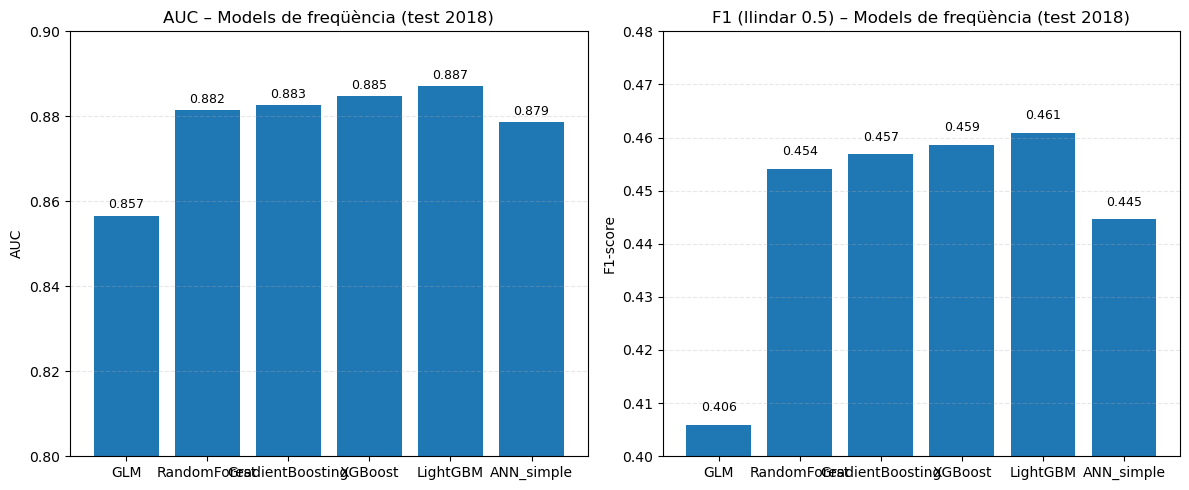

Figura 4.6.2 guardada a: data/model\fig_4_6_2_sev_MAE_RMSE_R2.png


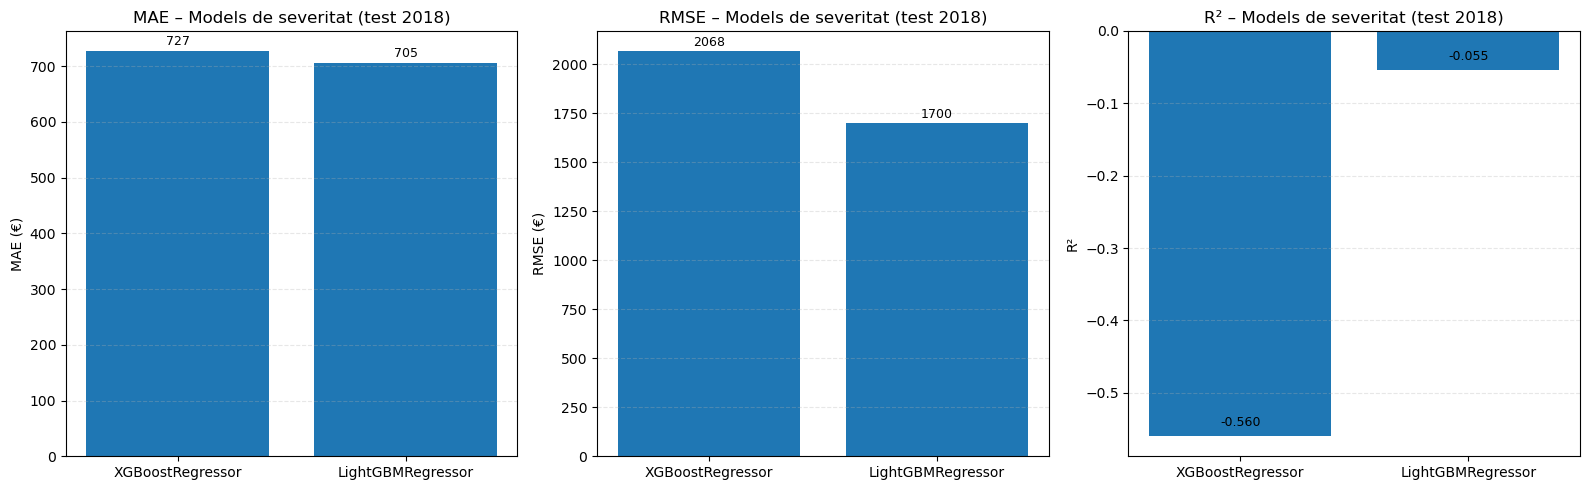


Taula 4.6.6 (resum final de models champion) guardada a: data/model\table_4_6_6_final_champions.csv

Contingut de la taula 4.6.6:
       target      model_champion metric_1  metric_1_value metric_2  \
0  Freqüència  LightGBMClassifier      AUC        0.887182   PR-AUC   
1   Severitat   LightGBMRegressor      MAE      705.409857     RMSE   

   metric_2_value metric_3  metric_3_value  metric_4  metric_4_value  
0        0.449415    Brier        0.105236  F1 (0.5)        0.460868  
1     1700.301388       R²       -0.054646                       NaN  

=== 4.6 RESULTATS OBTINGUTS – CODI COMPLETAT ===


In [10]:
# ==========================================================
# 4.6 RESULTATS OBTINGUTS
# ==========================================================
# Objectius d'aquest bloc:
#   - Carregar les taules de comparació de models (freq, sev, ràtio).
#   - Carregar les mètriques finals dels models "champion"
#     (LightGBMClassifier per a freqüència i LightGBMRegressor per a severitat).
#   - Generar:
#       * Taules de mètriques finals (4.6.1)
#       * Figures comparatives (4.6.2)
#       * Taula consolidada final de models champion (4.6.6)
#
# Fitxers esperats a data/model/:
#   - freq_model_comparison.csv
#   - sev_model_comparison.csv
#   - ratio_model_comparison.csv
#   - champion_freq_metrics.csv
#   - champion_sev_metrics.csv
#   - freq_shap_importance.csv (opcional, XAI)
#   - sev_shap_importance.csv  (opcional, XAI)
# ==========================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Per coherència amb la resta del projecte
MODEL_PATH = "data/model"
os.makedirs(MODEL_PATH, exist_ok=True)

# ----------------------------------------------------------
# 1. CARREGA DE TAULES I MÈTRIQUES CHAMPION
# ----------------------------------------------------------

freq_comp_path   = os.path.join(MODEL_PATH, "freq_model_comparison.csv")
sev_comp_path    = os.path.join(MODEL_PATH, "sev_model_comparison.csv")
ratio_comp_path  = os.path.join(MODEL_PATH, "ratio_model_comparison.csv")
champ_freq_path  = os.path.join(MODEL_PATH, "champion_freq_metrics.csv")
champ_sev_path   = os.path.join(MODEL_PATH, "champion_sev_metrics.csv")

freq_comp  = pd.read_csv(freq_comp_path)
sev_comp   = pd.read_csv(sev_comp_path)
ratio_comp = pd.read_csv(ratio_comp_path)

champ_freq = pd.read_csv(champ_freq_path)
champ_sev  = pd.read_csv(champ_sev_path)

print("freq_model_comparison:", freq_comp.shape)
print("sev_model_comparison :", sev_comp.shape)
print("ratio_model_comparison:", ratio_comp.shape)
print("champion_freq_metrics:", champ_freq.shape)
print("champion_sev_metrics :", champ_sev.shape)

# ----------------------------------------------------------
# 2. 4.6.1 TAULES DE MÈTRIQUES FINALS
# ----------------------------------------------------------
# Aquí simplement preparem taules netes que es poden exportar i
# després copiar al TFM (LaTeX / Word).
# ----------------------------------------------------------

# 2.1 Taula completa de models de freqüència (test 2018)
freq_metrics_table = freq_comp.copy()
freq_metrics_table.to_csv(
    os.path.join(MODEL_PATH, "table_4_6_1_freq_metrics.csv"),
    index=False,
)
print("\nTaula 4.6.1 (freqüència) guardada a: table_4_6_1_freq_metrics.csv")

# 2.2 Taula completa de models de severitat (test 2018)
sev_metrics_table = sev_comp.copy()
sev_metrics_table.to_csv(
    os.path.join(MODEL_PATH, "table_4_6_1_sev_metrics.csv"),
    index=False,
)
print("Taula 4.6.1 (severitat) guardada a: table_4_6_1_sev_metrics.csv")

# 2.3 Taula de model directe de ràtio (benchmark)
ratio_metrics_table = ratio_comp.copy()
ratio_metrics_table.to_csv(
    os.path.join(MODEL_PATH, "table_4_6_1_ratio_metrics.csv"),
    index=False,
)
print("Taula 4.6.1 (ràtio) guardada a: table_4_6_1_ratio_metrics.csv")

# ----------------------------------------------------------
# 3. 4.6.2 FIGURES COMPARATIVES
# ----------------------------------------------------------
# 3.1 Figura 4.6.1 – Comparació de models de freqüència (AUC i F1)
# 3.2 Figura 4.6.2 – Comparació de models de severitat (MAE, RMSE, R²)
# ----------------------------------------------------------

# 3.1 Comparació de models de FREQÜÈNCIA (AUC + F1)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

models_freq = freq_comp["model"]
auc_values  = freq_comp["test_auc"]
f1_values   = freq_comp["test_f1_0_5"]

# --- Subfigura esquerra: AUC ---
ax = axes[0]
bars_auc = ax.bar(models_freq, auc_values)
ax.set_title("AUC – Models de freqüència (test 2018)")
ax.set_ylabel("AUC")
ax.set_ylim(0.80, 0.90)
ax.grid(axis="y", linestyle="--", alpha=0.3)

for bar, val in zip(bars_auc, auc_values):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        val + 0.001,
        f"{val:.3f}",
        ha="center",
        va="bottom",
        fontsize=9,
    )

# --- Subfigura dreta: F1(0.5) ---
ax = axes[1]
bars_f1 = ax.bar(models_freq, f1_values)
ax.set_title("F1 (llindar 0.5) – Models de freqüència (test 2018)")
ax.set_ylabel("F1-score")
ax.set_ylim(0.40, 0.48)
ax.grid(axis="y", linestyle="--", alpha=0.3)

for bar, val in zip(bars_f1, f1_values):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        val + 0.002,
        f"{val:.3f}",
        ha="center",
        va="bottom",
        fontsize=9,
    )

plt.tight_layout()
fig_freq_path = os.path.join(MODEL_PATH, "fig_4_6_1_freq_AUC_F1.png")
plt.savefig(fig_freq_path, dpi=300, bbox_inches="tight")
print(f"\nFigura 4.6.1 guardada a: {fig_freq_path}")
plt.show()

# 3.2 Comparació de models de SEVERITAT (MAE, RMSE, R²)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

models_sev  = sev_comp["model"]
mae_values  = sev_comp["test_mae"]
rmse_values = sev_comp["test_rmse"]
r2_values   = sev_comp["test_r2"]

# --- Subfigura 1: MAE ---
ax = axes[0]
bars_mae = ax.bar(models_sev, mae_values)
ax.set_title("MAE – Models de severitat (test 2018)")
ax.set_ylabel("MAE (€)")
ax.grid(axis="y", linestyle="--", alpha=0.3)

for bar, val in zip(bars_mae, mae_values):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        val + 5,
        f"{val:.0f}",
        ha="center",
        va="bottom",
        fontsize=9,
    )

# --- Subfigura 2: RMSE ---
ax = axes[1]
bars_rmse = ax.bar(models_sev, rmse_values)
ax.set_title("RMSE – Models de severitat (test 2018)")
ax.set_ylabel("RMSE (€)")
ax.grid(axis="y", linestyle="--", alpha=0.3)

for bar, val in zip(bars_rmse, rmse_values):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        val + 10,
        f"{val:.0f}",
        ha="center",
        va="bottom",
        fontsize=9,
    )

# --- Subfigura 3: R² ---
ax = axes[2]
bars_r2 = ax.bar(models_sev, r2_values)
ax.set_title("R² – Models de severitat (test 2018)")
ax.set_ylabel("R²")
ax.grid(axis="y", linestyle="--", alpha=0.3)

for bar, val in zip(bars_r2, r2_values):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        val + 0.01,
        f"{val:.3f}",
        ha="center",
        va="bottom",
        fontsize=9,
    )

plt.tight_layout()
fig_sev_path = os.path.join(MODEL_PATH, "fig_4_6_2_sev_MAE_RMSE_R2.png")
plt.savefig(fig_sev_path, dpi=300, bbox_inches="tight")
print(f"Figura 4.6.2 guardada a: {fig_sev_path}")
plt.show()

# ----------------------------------------------------------
# 4. 4.6.6 TAULA CONSOLIDADA FINAL
# ----------------------------------------------------------
# Construïm una taula resum només amb els models "champion":
#   - Freqüència: LightGBMClassifier (champ_freq_metrics)
#   - Severitat : LightGBMRegressor (champ_sev_metrics)
# Aquesta taula es pot anomenar "Taula 4.6.6 – Resum final de models champion".
# ----------------------------------------------------------

# Ens assegurem que hi ha una sola fila a cada fitxer
assert len(champ_freq) == 1, "champion_freq_metrics hauria de tenir una sola fila"
assert len(champ_sev) == 1, "champion_sev_metrics hauria de tenir una sola fila"

row_freq = champ_freq.iloc[0]
row_sev  = champ_sev.iloc[0]

final_rows = [
    {
        "target": "Freqüència",
        "model_champion": row_freq["model"],
        "metric_1": "AUC",
        "metric_1_value": row_freq["test_auc"],
        "metric_2": "PR-AUC",
        "metric_2_value": row_freq["test_pr_auc"],
        "metric_3": "Brier",
        "metric_3_value": row_freq["test_brier"],
        "metric_4": "F1 (0.5)",
        "metric_4_value": row_freq["test_f1_0_5"],
    },
    {
        "target": "Severitat",
        "model_champion": row_sev["model"],
        "metric_1": "MAE",
        "metric_1_value": row_sev["test_mae"],
        "metric_2": "RMSE",
        "metric_2_value": row_sev["test_rmse"],
        "metric_3": "R²",
        "metric_3_value": row_sev["test_r2"],
        "metric_4": "",
        "metric_4_value": np.nan,
    },
]

final_table = pd.DataFrame(final_rows)

final_consol_path = os.path.join(MODEL_PATH, "table_4_6_6_final_champions.csv")
final_table.to_csv(final_consol_path, index=False)

print(f"\nTaula 4.6.6 (resum final de models champion) guardada a: {final_consol_path}")
print("\nContingut de la taula 4.6.6:")
print(final_table)

print("\n=== 4.6 RESULTATS OBTINGUTS – CODI COMPLETAT ===")
